# 📘 Notebook 01 — EDA & Preparação do Dataset (Renda x Imóveis x Dívidas)

Projeto: **Clusterização em 3D com K-Means**  
Disciplina: **Aprendizado de Máquina Não Supervisionado** — Senac DF  
Autores: **Anderson de Matos Guimarães, Renan Ost, Gustavo Stefano Thomazinho**

**Objetivo deste notebook**  
Explorar o dataset bruto de **Distribuição de Renda por Centis** (IRPF), entender o negócio, selecionar **3 variáveis contínuas** e produzir um dataset **limpo e padronizado** para o Notebook 02 (clusterização e visualização 3D).

## 🎯 Escopo & Entregáveis

**Vamos:**
1. Carregar e validar o CSV bruto.  
2. Inspecionar colunas, tipos, nulos, duplicatas e consistência.  
3. Documentar o **dicionário de dados** (visão de negócio).  
4. Definir a **amostragem reprodutível** (300–500 linhas) com critérios claros.  
5. Selecionar e preparar as **3 variáveis**:
   - `rtb_soma_centil` (renda),
   - `bens_imoveis` (patrimônio),
   - `dividas_onus` (endividamento).
6. Tratar outliers e zeros estruturais quando necessário (sem distorcer a realidade).  
7. Escalonar (opcional) e **salvar** o dataset tratado (+ `metadata.json`).  

**Saídas:**
- `data/processed/distribuicao-renda-3vars.csv`  
- `data/processed/distribuicao-renda-3vars.metadata.json`  
- Gráficos e anotações que justificam as decisões.

## ✅ Critérios do Professor (como atendemos)

- **Entradas (300–500)** → definiremos uma **amostra reprodutível** com base em (ano, entes federativos, centis).  
- **Dados granulares** → centis (100 cortes por distribuição de RTB) garantem granularidade.  
- **Numéricos contínuos** → valores monetários (R$) para as 3 variáveis.  
- **Exatamente 3 variáveis** → renda, patrimônio (imóveis) e dívidas (3D pronto).  
- **Notebook estilo IDEB** → manteremos seções claras, decisões justificadas e, no 02, poderemos comparar diferentes *k* (e opcionalmente usar dois anos se for relevante).

## 🗂️ Fonte de Dados, Licença e Paths

- **Fonte oficial**: Receita Federal — Distribuição de Renda por Centis.  
- **Arquivo bruto**: `data/raw/distribuicao-renda.csv`  
- **Arquivo tratado (3 variáveis)**: `data/processed/distribuicao-renda-3vars.csv`

> Observação: trabalharemos com unidades conforme o arquivo (muitos campos estão em **R$ milhões**). Faremos padronização de nomes e registraremos as unidades no metadado.

## 🏢 Entendimento do Negócio (resumo)

O dataset agrega informações de declarações de **IRPF** por **centis de renda tributável bruta (RTB)**.  
Cada linha representa um **grupo** (centil) para um **ente federativo** em um **ano**.  
As colunas trazem somatórios de rendimentos, bens/direitos, despesas dedutíveis, dívidas, etc.

**Hipóteses de leitura econômica (para orientar a análise):**
- `rtb_soma_centil` aproxima **capacidade de geração de renda** do grupo.  
- `bens_imoveis` aproxima **acumulação patrimonial** estável.  
- `dividas_onus` aproxima **alavancagem/endividamento**.  

Essas três dimensões juntas formam um **espaço 3D** que deveria segregar perfis de grupos (baixa renda com baixa riqueza e baixa dívida vs. alta renda com alta riqueza e dívida variável, etc.).

## 📖 Dicionário de Dados (campos relevantes ao projeto)

| Coluna original (exemplo)                 | Nome padronizado        | Tipo      | Unidade         | Observação de negócio |
|-------------------------------------------|-------------------------|-----------|-----------------|-----------------------|
| Ano-calendário                            | `ano`                   | int       | ano             | Ano da declaração     |
| Ente Federativo                           | `uf`                    | string    | —               | Estado/Agregado       |
| Centil                                    | `centil`                | float     | 1–100           | Corte por RTB         |
| Rend. Trib. — Soma da RTB do Centil       | `rtb_soma_centil`       | float     | R$ milhões      | **Renda** (capacidade)|
| Bens e Direitos — Imóveis                 | `bens_imoveis`          | float     | R$ milhões      | **Patrimônio**        |
| Dívidas e Ônus                            | `dividas_onus`          | float     | R$ milhões      | **Endividamento**     |

> Notas:
> - Confirmaremos nomes exatos das colunas do CSV bruto e mapearemos para os padronizados acima.  
> - Se necessário, convertendo vírgulas decimais e removendo formatações.

In [1]:
# Imports, seed e paths (corrigidos para notebook em /notebooks)
from __future__ import annotations
import os, json, math, textwrap, re, sys
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda v: f"{v:,.3f}")

# Paths
ROOT = Path("..").resolve()  # sobe um nível a partir de /notebooks
DATA_RAW = ROOT / "data" / "raw" / "distribuicao-renda.csv"
DATA_PROCESSED_DIR = ROOT / "data" / "processed"
DATA_PROCESSED = DATA_PROCESSED_DIR / "distribuicao-renda-3vars.csv"
METADATA = DATA_PROCESSED_DIR / "distribuicao-renda-3vars.metadata.json"
FIG_DIR = ROOT / "reports" / "figures"
for p in [DATA_PROCESSED_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

FALLBACK_FILE = Path("/mnt/data/distribuicao-renda.csv")
if not DATA_RAW.exists() and FALLBACK_FILE.exists():
    print(f"[INFO] Usando fallback: {FALLBACK_FILE}")
    DATA_RAW = FALLBACK_FILE

print("ROOT        :", ROOT)
print("DATA_RAW    :", DATA_RAW)
print("PROCESSED   :", DATA_PROCESSED)
print("FIG_DIR     :", FIG_DIR)

ROOT        : C:\QuartoSemestre\kmeans-3d-cluster
DATA_RAW    : C:\QuartoSemestre\kmeans-3d-cluster\data\raw\distribuicao-renda.csv
PROCESSED   : C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.csv
FIG_DIR     : C:\QuartoSemestre\kmeans-3d-cluster\reports\figures


In [2]:
def read_csv_br(filepath: Path) -> pd.DataFrame:
    """
    Leitura robusta para CSV com possíveis variações:
    - separador ',' ou ';'
    - decimal '.' ou ','
    - encoding 'utf-8' ou 'latin-1'
    Retorna o DataFrame lido com detecção automática.
    """
    trials = [
        dict(sep=";", decimal=",", encoding="utf-8", engine="python"),
        dict(sep=",", decimal=",", encoding="utf-8", engine="python"),
        dict(sep=";", decimal=".", encoding="utf-8", engine="python"),
        dict(sep=",", decimal=".", encoding="utf-8", engine="python"),
        dict(sep=";", decimal=",", encoding="latin-1", engine="python"),
        dict(sep=",", decimal=",", encoding="latin-1", engine="python"),
    ]
    last_err = None
    for opts in trials:
        try:
            df = pd.read_csv(filepath, **opts)
            if df.shape[1] == 1:
                last_err = RuntimeError("provável separador incorreto (1 coluna)")
                continue
            print(f"[OK] Leitura com parâmetros: {opts}")
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Falha ao ler {filepath}: {last_err}")

def snake(s: str) -> str:
    s2 = re.sub(r"[^\w]+", "_", s.strip().lower(), flags=re.UNICODE)
    s2 = re.sub(r"_{2,}", "_", s2).strip("_")
    return s2

def find_col(candidates: List[str], patterns: List[str]) -> str | None:
    for c in candidates:
        cl = c.lower()
        ok = True
        for pat in patterns:
            ors = pat.split("|")
            if not any(o in cl for o in ors):
                ok = False
                break
        if ok:
            return c
    return None

def quantiles_report(s: pd.Series, qs=(0.5, 0.9, 0.95, 0.99)) -> pd.Series:
    qv = s.quantile(q=list(qs))
    qv.index = [f"q{int(q*100):02d}" for q in qs]
    return qv

def savefig(path: Path):
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    print(f"[FIG] salvo: {path}")

## 🔍 EDA do Arquivo Bruto

Nesta seção faremos:
1. **Leitura segura** (encoding, separador, decimal).  
2. **Shape, colunas, tipos, nulos, duplicatas**.  
3. **Estatísticas descritivas** (mediana, p95, p99) para entender caudas.  
4. **Sanidade de chaves lógicas**: (ano, uf, centil) sem duplicidades por registro.  
5. **Distribuições**:
   - Histogramas de `rtb_soma_centil`, `bens_imoveis`, `dividas_onus`.  
   - Scatterpairs para relações bivariadas.  
6. **Zeros e “ausências esperadas”**: bens ou dívidas podem ter zeros; não confundir com *missing*.  
7. **Outliers**: avaliar se são fenômeno real (altíssima concentração no topo) → provavelmente **não remover**, apenas documentar e considerar **log-transform** opcional.

In [3]:
df_raw = read_csv_br(DATA_RAW)

print("\n# VISÃO GERAL")
print("shape:", df_raw.shape)
display(df_raw.head(10))

print("\n# COLUNAS")
print(list(df_raw.columns))

print("\n# TIPOS")
display(df_raw.dtypes)

print("\n# NULOS (%)")
display((df_raw.isna().mean() * 100).round(2).sort_values(ascending=False))

print("\n# Duplicatas (linhas idênticas):", df_raw.duplicated().sum())

[OK] Leitura com parâmetros: {'sep': ';', 'decimal': ',', 'encoding': 'utf-8', 'engine': 'python'}

# VISÃO GERAL
shape: (46350, 24)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],Rendimentos Tributaveis - Média da RTB do Centil [R$],Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],Rendimentos Isentos - Lucros e dividendos [R$ milhões],Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões],Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões],Despesas Dedutíveis - Previdência [R$ milhões],Despesas Dedutíveis - Dependentes [R$ milhões],Despesas Dedutíveis - Instrução [R$ milhões],Despesas Dedutíveis - Médicas [R$ milhões],Despesas Dedutíveis - Pensão Alimentícia [R$ milhões],Despesas Dedutíveis - Livro-Caixa [R$ milhões],Imposto Devido [R$ milhões],Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Móveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Bens e Direitos - Outros Bens e Direitos [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,235.61,481.27,27.37,"1.694,49",NaN,NaN,NaN,NaN,NaN,NaN,0.16,"5.281,59",686.21,"6.549,15","1.006,40","1.610,39"
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,208.74,483.44,29.36,"1.675,01",NaN,NaN,NaN,NaN,NaN,NaN,0.22,"5.295,48",668.82,"5.762,77",681.75,694.12
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,219.96,459.87,27.63,"1.683,04",NaN,NaN,NaN,NaN,NaN,NaN,0.31,"5.566,27",670.64,"5.451,95",377.17,650.98
3,2006,BRASIL,4,241.563,NaN,NaN,NaN,NaN,257.01,481.93,31.77,"1.699,89",NaN,NaN,NaN,NaN,NaN,NaN,0.17,"5.860,02",678.44,"6.104,09",256.16,"1.079,20"
4,2006,BRASIL,5,241.562,NaN,NaN,NaN,NaN,249.88,464.23,28.11,"1.697,17",NaN,NaN,NaN,NaN,NaN,NaN,0.17,"5.193,31",682.38,"5.592,52",269.28,671.97
5,2006,BRASIL,6,241.563,NaN,NaN,NaN,NaN,225.07,454.74,24.73,"1.604,68",NaN,NaN,NaN,NaN,NaN,NaN,0.13,"5.193,68",662.55,"6.611,62",265.35,612.02
6,2006,BRASIL,7,241.562,NaN,NaN,NaN,NaN,240.87,460.86,27.69,"1.608,30",NaN,NaN,NaN,NaN,NaN,NaN,0.08,"5.316,54",701.6,"5.652,74",389.85,863.93
7,2006,BRASIL,8,241.563,NaN,NaN,NaN,NaN,244.43,569.25,29.76,"1.751,91",NaN,NaN,NaN,NaN,NaN,NaN,0.1,"5.443,09",673.85,"6.197,00",336.04,629.92
8,2006,BRASIL,9,241.562,NaN,NaN,NaN,NaN,176.14,536.98,24.94,"1.581,53",NaN,NaN,NaN,NaN,NaN,NaN,0.21,"5.274,17",658.96,"5.903,26",232.22,933.64
9,2006,BRASIL,10,241.563,NaN,NaN,NaN,NaN,259.26,547.41,30.08,"1.756,96",NaN,NaN,NaN,NaN,NaN,NaN,0.16,"5.219,60",687.21,"5.627,35",281.04,685.59



# COLUNAS
['Ano-calendário', 'Ente Federativo', 'Centil', 'Quantidade de Contribuintes', 'Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]', 'Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]', 'Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]', 'Rendimentos Tributaveis - Média da RTB do Centil [R$]', 'Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões]', 'Rendimentos Isentos - Lucros e dividendos [R$ milhões]', 'Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões]', 'Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões]', 'Despesas Dedutíveis - Previdência [R$ milhões]', 'Despesas Dedutíveis - Dependentes [R$ milhões]', 'Despesas Dedutíveis - Instrução [R$ milhões]', 'Despesas Dedutíveis - Médicas [R$ milhões]', 'Despesas Dedutíveis - Pensão Alimentícia [R$ milhões]', 'Despesas Dedutíveis - Livro-Caixa [R$ milhões]', 'Imposto Devido [R$ milhões]', 'Bens e Direitos - Imóveis [R$ milhões]', 'Bens e Direito

Ano-calendário                                                                   int64
Ente Federativo                                                                 object
Centil                                                                          object
Quantidade de Contribuintes                                                    float64
Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]         object
Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]                    object
Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]                  object
Rendimentos Tributaveis - Média da RTB do Centil [R$]                           object
Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões]                           object
Rendimentos Isentos - Lucros e dividendos [R$ milhões]                          object
Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões]     object
Rendimentos Isentos - Outros Rendimentos Is


# NULOS (%)


Imposto Devido [R$ milhões]                                                   17.620
Despesas Dedutíveis - Livro-Caixa [R$ milhões]                                14.580
Despesas Dedutíveis - Pensão Alimentícia [R$ milhões]                          8.420
Despesas Dedutíveis - Instrução [R$ milhões]                                   7.800
Despesas Dedutíveis - Médicas [R$ milhões]                                     7.510
Despesas Dedutíveis - Previdência [R$ milhões]                                 7.400
Despesas Dedutíveis - Dependentes [R$ milhões]                                 7.390
Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]        7.370
Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]                   7.370
Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]                 7.370
Rendimentos Tributaveis - Média da RTB do Centil [R$]                          7.370
Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R


# Duplicatas (linhas idênticas): 0


In [4]:
cols = list(df_raw.columns)

col_ano    = find_col(cols, ["ano", "calendario|calendário"])
col_uf     = find_col(cols, ["ente|uf|federativo"])
col_centil = find_col(cols, ["centil"])

col_rtb_soma   = find_col(cols, ["rendimentos|rtb", "soma|somatorio|somatório"])
col_bens_imov  = find_col(cols, ["bens|direitos", "imoveis|imóveis"])
col_dividas    = find_col(cols, ["dividas|dívidas", "onus|ônus"])

mapping = {
    col_ano: "ano",
    col_uf: "uf",
    col_centil: "centil",
    col_rtb_soma: "rtb_soma_centil",
    col_bens_imov: "bens_imoveis",
    col_dividas: "dividas_onus",
}

print("# MAPEAMENTO PROPOSTO")
display(mapping)

missing_keys = [k for k in mapping if k is None]
if missing_keys:
    raise ValueError("Não consegui detectar automaticamente algumas colunas. Revise os padrões desta célula e rode novamente.")

df = df_raw.rename(columns={k: v for k, v in mapping.items()})
df.columns = [snake(c) for c in df.columns]
display(df.head(3))

# MAPEAMENTO PROPOSTO


{'Ano-calendário': 'ano',
 'Ente Federativo': 'uf',
 'Centil': 'centil',
 'Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]': 'rtb_soma_centil',
 'Bens e Direitos - Imóveis [R$ milhões]': 'bens_imoveis',
 'Dívidas e Ônus [R$ milhões]': 'dividas_onus'}

,ano,uf,centil,quantidade_de_contribuintes,rendimentos_tributaveis_limite_superior_da_rtb_do_centil_r_milhões,rtb_soma_centil,rendimentos_tributaveis_rtb_acumulada_do_centil_r_milhões,rendimentos_tributaveis_média_da_rtb_do_centil_r,rendimentos_sujeitos_à_tribut_exclusiva_r_milhões,rendimentos_isentos_lucros_e_dividendos_r_milhões,rendimentos_isentos_rendim_sócio_titular_me_epp_opt_simples_r_milhões,rendimentos_isentos_outros_rendimentos_isentos_r_milhões,despesas_dedutíveis_previdência_r_milhões,despesas_dedutíveis_dependentes_r_milhões,despesas_dedutíveis_instrução_r_milhões,despesas_dedutíveis_médicas_r_milhões,despesas_dedutíveis_pensão_alimentícia_r_milhões,despesas_dedutíveis_livro_caixa_r_milhões,imposto_devido_r_milhões,bens_imoveis,bens_e_direitos_móveis_r_milhões,bens_e_direitos_financeiros_r_milhões,bens_e_direitos_outros_bens_e_direitos_r_milhões,dividas_onus
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,235.61,481.27,27.37,"1.694,49",NaN,NaN,NaN,NaN,NaN,NaN,0.16,"5.281,59",686.21,"6.549,15","1.006,40","1.610,39"
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,208.74,483.44,29.36,"1.675,01",NaN,NaN,NaN,NaN,NaN,NaN,0.22,"5.295,48",668.82,"5.762,77",681.75,694.12
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,219.96,459.87,27.63,"1.683,04",NaN,NaN,NaN,NaN,NaN,NaN,0.31,"5.566,27",670.64,"5.451,95",377.17,650.98


In [5]:
# === Tipagem robusta ===
df["ano"] = (
    df["ano"].astype(str).str.extract(r"(\d{4})", expand=False)
      .pipe(pd.to_numeric, errors="coerce")
      .astype("Int64")
)

centil_raw = (
    df["centil"]
      .astype(str)
      .str.replace(",", ".", regex=False)
      .str.extract(r"(\d+(?:\.\d+)?)", expand=False)
)
df["centil"] = pd.to_numeric(centil_raw, errors="coerce")

for c in ["rtb_soma_centil", "bens_imoveis", "dividas_onus"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["rtb_soma_centil", "bens_imoveis", "dividas_onus"])

mask_centil = (df["centil"] >= 1) & (df["centil"] <= 100)
rem_out = (~mask_centil).sum()
if rem_out:
    print(f"[INFO] Removendo {rem_out} linhas com centil fora de [1,100]")
df = df[mask_centil].copy()

dup = df.duplicated(subset=["ano", "uf", "centil"]).sum()
print("Duplicidades em (ano, uf, centil):", dup)

print("Shape após limpeza básica:", df.shape)
display(df[["ano", "uf", "centil", "rtb_soma_centil", "bens_imoveis", "dividas_onus"]].head())

[INFO] Removendo 3332 linhas com centil fora de [1,100]
Duplicidades em (ano, uf, centil): 0
Shape após limpeza básica: (30081, 24)


,ano,uf,centil,rtb_soma_centil,bens_imoveis,dividas_onus
120,2006,AC,1.000,0.000,12.290,0.000
121,2006,AC,2.000,0.000,1.430,1.830
122,2006,AC,3.000,0.000,1.830,0.000
123,2006,AC,4.000,0.000,1.070,0.210
124,2006,AC,5.000,0.000,1.220,0.340


In [6]:
num_cols = ["rtb_soma_centil", "bens_imoveis", "dividas_onus"]
display(df[num_cols].describe().T)

qtab = pd.concat([quantiles_report(df[c]) for c in num_cols], axis=1).T
qtab.columns = qtab.columns.str.upper()
display(qtab)

print("anos:", sorted(df["ano"].dropna().unique().tolist())[:10], "...")
print("UFs (amostra):", df["uf"].dropna().unique()[:10])
print("linhas totais:", len(df))

,count,mean,std,min,25%,50%,75%,max
rtb_soma_centil,"30,081.000",158.879,166.014,0.000,41.970,98.050,218.800,998.050
bens_imoveis,"30,081.000",206.370,237.359,0.050,36.760,105.180,289.170,999.790
dividas_onus,"30,081.000",41.070,53.450,0.000,6.090,19.820,56.730,928.450


,Q50,Q90,Q95,Q99
rtb_soma_centil,98.050,398.430,513.850,743.924
bens_imoveis,105.180,596.050,760.440,941.902
dividas_onus,19.820,112.440,150.190,218.366


anos: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015] ...
UFs (amostra): ['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA']
linhas totais: 30081


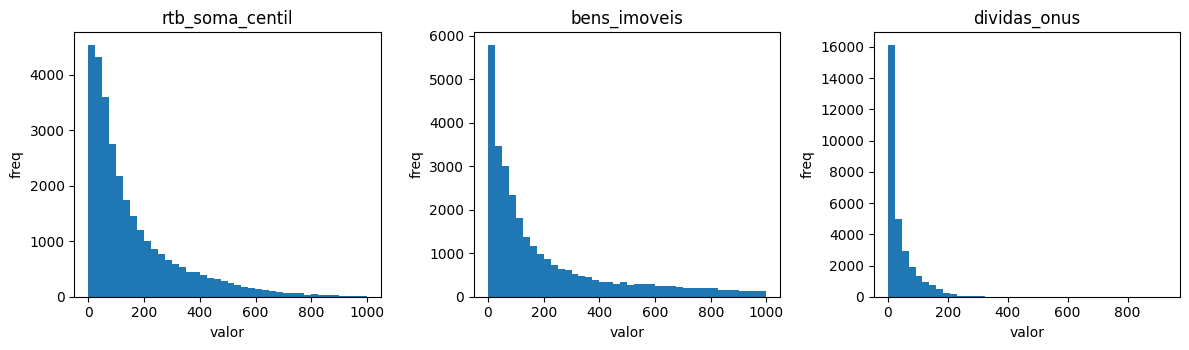

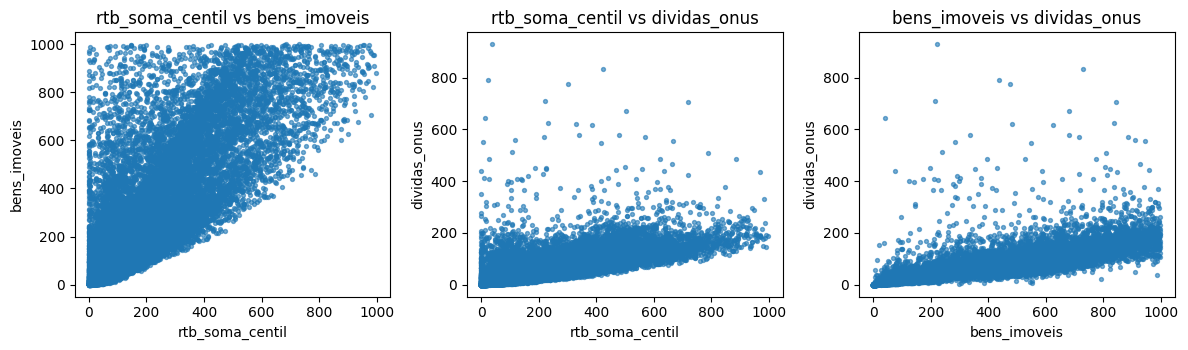

In [7]:
plt.figure(figsize=(12,3.6))
for i,c in enumerate(num_cols, 1):
    plt.subplot(1,3,i)
    plt.hist(df[c].dropna(), bins=40)
    plt.title(c)
    plt.xlabel("valor")
    plt.ylabel("freq")
plt.tight_layout()
plt.show()

pairs = [("rtb_soma_centil","bens_imoveis"),
         ("rtb_soma_centil","dividas_onus"),
         ("bens_imoveis","dividas_onus")]

plt.figure(figsize=(12,3.6))
for i,(x,y) in enumerate(pairs,1):
    plt.subplot(1,3,i)
    plt.scatter(df[x], df[y], s=8, alpha=0.6)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{x} vs {y}")
plt.tight_layout()
plt.show()

for c in num_cols:
    df[f"log_{c}"] = np.log1p(df[c].clip(lower=0))

## 🧪 Estratégia de Amostragem (300–500 linhas)

**Princípio**: reprodutibilidade + representatividade.

**Passos**:
1. Escolher **um ano-base** (tipicamente o mais recente disponível).  
2. Calcular o total de linhas (UF × centis) e **estimar** quantos UFs e centis precisamos para cair entre **300–500**.  
3. Estratégias possíveis (a definir após ver o shape real):
   - **E1 (recomendada)**: Fixar ano; **usar todos os UFs**; selecionar um **intervalo contínuo de centis** (ex.: 1–20, 30–60, 90–100) que dê ~300–500.  
   - **E2**: Fixar ano; **amostrar UFs** (estratificado por região) e usar **todos os centis** desses UFs.  
4. Fixar uma **seed** para qualquer amostragem aleatória.  
5. Registrar a regra no `metadata.json`.

> Justificativa didática: manter **centis contíguos** preserva estrutura da distribuição e facilita interpretar clusters (baixa, média, alta renda).

In [8]:
def choose_year_base(data: pd.DataFrame) -> int:
    anos = data["ano"].dropna().astype(int)
    year = int(anos.max())
    print(f"[ANO-BASE] Selecionado automaticamente: {year}")
    return year

def sample_rows(data: pd.DataFrame, target_min: int = 300, target_max: int = 500) -> pd.DataFrame:
    year = choose_year_base(data)
    dfy = data.query("ano == @year").copy()
    possiveis_agregados = {"brasil", "nacional", "todos", "agregado"}
    dfy["uf_lc"] = dfy["uf"].astype(str).str.lower()
    dfy = dfy[~dfy["uf_lc"].isin(possiveis_agregados)].drop(columns=["uf_lc"])

    n_uf = dfy["uf"].nunique()
    print(f"[AMOSTRA] UFs distintos no ano {year}: {n_uf}")

    N_min = math.ceil(target_min / n_uf)
    N_max = min(100, math.floor(target_max / n_uf))
    N = max(1, min(N_max, max(N_min, 10)))
    print(f"[AMOSTRA] Intervalo de centis: 1..{N} (alvo {target_min}-{target_max})")

    df_sample = dfy[dfy["centil"].between(1, N, inclusive="both")].copy()
    print(f"[AMOSTRA] Linhas resultantes: {len(df_sample)}")
    return df_sample

df_sample = sample_rows(df)
display(df_sample.head())
display(df_sample.tail())
print("shape:", df_sample.shape)

[ANO-BASE] Selecionado automaticamente: 2020
[AMOSTRA] UFs distintos no ano 2020: 22
[AMOSTRA] Intervalo de centis: 1..14 (alvo 300-500)
[AMOSTRA] Linhas resultantes: 150


,ano,uf,centil,quantidade_de_contribuintes,rendimentos_tributaveis_limite_superior_da_rtb_do_centil_r_milhões,rtb_soma_centil,rendimentos_tributaveis_rtb_acumulada_do_centil_r_milhões,rendimentos_tributaveis_média_da_rtb_do_centil_r,rendimentos_sujeitos_à_tribut_exclusiva_r_milhões,rendimentos_isentos_lucros_e_dividendos_r_milhões,rendimentos_isentos_rendim_sócio_titular_me_epp_opt_simples_r_milhões,rendimentos_isentos_outros_rendimentos_isentos_r_milhões,despesas_dedutíveis_previdência_r_milhões,despesas_dedutíveis_dependentes_r_milhões,despesas_dedutíveis_instrução_r_milhões,despesas_dedutíveis_médicas_r_milhões,despesas_dedutíveis_pensão_alimentícia_r_milhões,despesas_dedutíveis_livro_caixa_r_milhões,imposto_devido_r_milhões,bens_imoveis,bens_e_direitos_móveis_r_milhões,bens_e_direitos_financeiros_r_milhões,bens_e_direitos_outros_bens_e_direitos_r_milhões,dividas_onus,log_rtb_soma_centil,log_bens_imoveis,log_dividas_onus
43386,2020,AC,7.000,788.000,"3.800,00",1.080,1.08,"1.372,86",1.2,5.54,0.87,14.34,0.05,0.060,0.000,0.03,0,NaN,NaN,48.230,8.29,53.63,6.57,5.030,0.732,3.897,1.797
43387,2020,AC,8.000,788.000,"8.000,00",4.440,5.52,"5.629,50",1.17,2.16,0.82,8.54,0.11,0.140,0.020,0.12,0.01,NaN,NaN,26.910,6.37,21.29,1.63,4.140,1.694,3.329,1.637
43388,2020,AC,9.000,787.000,"12.000,00",7.940,13.46,"10.088,18",1.08,1.49,0.97,7.98,0.23,0.180,0.050,0.12,0.01,NaN,NaN,28.370,5.98,19.07,0.92,2.300,2.191,3.380,1.194
43389,2020,AC,10.000,788.000,"12.675,65",9.720,23.18,"12.333,10",0.41,6.15,3,2.88,0.16,0.110,0.010,0.06,0.01,NaN,NaN,23.700,6.69,43.17,1.31,2.760,2.372,3.207,1.324
43390,2020,AC,11.000,788.000,"15.000,00",10.890,34.06,"13.815,41",0.96,10.55,1.35,6.02,0.22,0.100,0.020,0.16,0.03,0.01,0,28.360,4.78,28.07,0.46,3.330,2.476,3.380,1.466


,ano,uf,centil,quantidade_de_contribuintes,rendimentos_tributaveis_limite_superior_da_rtb_do_centil_r_milhões,rtb_soma_centil,rendimentos_tributaveis_rtb_acumulada_do_centil_r_milhões,rendimentos_tributaveis_média_da_rtb_do_centil_r,rendimentos_sujeitos_à_tribut_exclusiva_r_milhões,rendimentos_isentos_lucros_e_dividendos_r_milhões,rendimentos_isentos_rendim_sócio_titular_me_epp_opt_simples_r_milhões,rendimentos_isentos_outros_rendimentos_isentos_r_milhões,despesas_dedutíveis_previdência_r_milhões,despesas_dedutíveis_dependentes_r_milhões,despesas_dedutíveis_instrução_r_milhões,despesas_dedutíveis_médicas_r_milhões,despesas_dedutíveis_pensão_alimentícia_r_milhões,despesas_dedutíveis_livro_caixa_r_milhões,imposto_devido_r_milhões,bens_imoveis,bens_e_direitos_móveis_r_milhões,bens_e_direitos_financeiros_r_milhões,bens_e_direitos_outros_bens_e_direitos_r_milhões,dividas_onus,log_rtb_soma_centil,log_bens_imoveis,log_dividas_onus
46249,2020,TO,10.000,1.688,"11.489,00",17.060,35.53,"10.105,34",3.23,8.85,2.86,17.46,0.35,0.510,0.060,0.16,0.02,NaN,0,207.670,24.17,68.11,10.03,15.140,2.894,5.341,2.781
46250,2020,TO,11.000,1.688,"12.487,00",20.400,55.93,"12.086,47",1.88,42.33,9.1,19.52,0.44,0.300,0.060,0.16,0.02,0,NaN,161.320,27.24,123.33,16.69,21.740,3.063,5.090,3.124
46251,2020,TO,12.000,1.689,"12.534,00",21.130,77.07,"12.512,81",0.77,42.09,19.44,5.08,0.62,0.340,0.100,0.12,0.04,NaN,NaN,144.760,41.39,189.98,20.56,21.720,3.097,4.982,3.123
46252,2020,TO,13.000,1.688,"12.540,00",21.170,98.23,"12.538,88",0.45,29.19,10.27,2.68,0.37,0.150,0.020,0.08,0.03,NaN,NaN,152.290,30.56,102.17,12.86,12.010,3.099,5.032,2.566
46253,2020,TO,14.000,1.688,"14.055,74",22.270,120.5,"13.191,25",10.47,17.65,6.63,17.04,0.36,0.400,0.090,0.31,0.05,0.01,NaN,173.040,24.71,109.19,18.78,27.500,3.147,5.159,3.350


shape: (150, 27)


In [9]:
dups = df_sample.duplicated(subset=["ano", "uf", "centil"]).sum()
print("Duplicidades (ano,uf,centil) na amostra:", dups)

print("Nulos nas variáveis selecionadas:")
display(df_sample[["rtb_soma_centil", "bens_imoveis", "dividas_onus"]].isna().sum())

display(df_sample[["rtb_soma_centil", "bens_imoveis", "dividas_onus"]].describe().T)

Duplicidades (ano,uf,centil) na amostra: 0
Nulos nas variáveis selecionadas:


rtb_soma_centil    0
bens_imoveis       0
dividas_onus       0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
rtb_soma_centil,150.000,34.303,30.672,0.000,11.360,26.695,49.905,141.450
bens_imoveis,150.000,255.356,244.414,7.650,86.800,157.360,402.270,992.240
dividas_onus,150.000,61.326,96.784,0.190,13.398,27.280,83.510,928.450


## 🧼 Limpeza & Transformações

1. **Padronizar nomes** de colunas para *snake_case*.  
2. **Selecionar colunas**: `ano`, `uf`, `centil`, `rtb_soma_centil`, `bens_imoveis`, `dividas_onus`.  
3. **Tipos corretos** (int/float); tratar decimal com vírgula, se houver.  
4. **Checagens de integridade**:
   - `centil` ∈ [1, 100]  
   - Sem duplicidade para (ano, uf, centil) na amostra.  
5. **Tratamento de escalas**:
   - Manter valores em **R$ milhões** (consistência com a fonte).  
   - Criar **versão log-transform** para visualização, se necessário (`log1p`).  
6. **Escalonamento (para o Notebook 02)**:
   - Salvar **dados crus** e, opcionalmente, uma **cópia escalada** (StandardScaler/MinMax) para K-Means.  
   - A decisão final de escalonamento será aplicada no Notebook 02; aqui apenas deixamos a função e um preview.

In [10]:
cols_final = ["ano", "uf", "centil", "rtb_soma_centil", "bens_imoveis", "dividas_onus"]
df_out = df_sample[cols_final].copy()

# Salvar
DATA_PROCESSED.parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(DATA_PROCESSED, index=False)
print(f"[SALVO] {DATA_PROCESSED} ({len(df_out)} linhas)")

# Metadados
metadata = {
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "source_file": str(DATA_RAW),
    "output_file": str(DATA_PROCESSED),
    "year_base": int(df_out["ano"].dropna().max()) if len(df_out) else None,
    "sampling_rule": "ano=max; UFs=all (excl. agregados nacionais); centis=1..N tal que linhas entre 300-500",
    "n_rows": int(len(df_out)),
    "units": {
        "rtb_soma_centil": "R$ milhões (somatório por centil)",
        "bens_imoveis": "R$ milhões (somatório por UF-centil)",
        "dividas_onus": "R$ milhões (somatório por UF-centil)",
    },
    "notes": [
        "Colunas padronizadas para snake_case.",
        "Zeros podem representar ausência real de bens/dívidas.",
        "EDA completa salva em reports/figures/.",
        "Transformações log(1+x) usadas apenas para visualização na EDA.",
    ],
    "random_seed": RANDOM_SEED,
    "authors": [
        "Anderson de Matos Guimarães",
        "Renan Ost",
        "Gustavo Stefano Thomazinho",
    ],
}
import json
with open(METADATA, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print(f"[SALVO] {METADATA}")

[SALVO] C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.csv (150 linhas)
[SALVO] C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-3vars.metadata.json


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df_out[["rtb_soma_centil", "bens_imoveis", "dividas_onus"]].values

sc_std = StandardScaler()
X_std = sc_std.fit_transform(X)

sc_mm = MinMaxScaler()
X_mm = sc_mm.fit_transform(X)

print("Preview StandardScaler (primeiras 5 linhas):")
print(pd.DataFrame(X_std, columns=["rtb_std","imoveis_std","dividas_std"]).head())

print("\nPreview MinMaxScaler (primeiras 5 linhas):")
print(pd.DataFrame(X_mm, columns=["rtb_mm","imoveis_mm","dividas_mm"]).head())

Preview StandardScaler (primeiras 5 linhas):
   rtb_std  imoveis_std  dividas_std
0   -1.087       -0.850       -0.584
1   -0.977       -0.938       -0.593
2   -0.862       -0.932       -0.612
3   -0.804       -0.951       -0.607
4   -0.766       -0.932       -0.601

Preview MinMaxScaler (primeiras 5 linhas):
   rtb_mm  imoveis_mm  dividas_mm
0   0.008       0.041       0.005
1   0.031       0.020       0.004
2   0.056       0.021       0.002
3   0.069       0.016       0.003
4   0.077       0.021       0.003


## 💾 Persistência dos Resultados

- **CSV final**: `data/processed/distribuicao-renda-3vars.csv`  
  - Colunas: `ano, uf, centil, rtb_soma_centil, bens_imoveis, dividas_onus`  
  - Somente linhas da **amostra definida**.  
- **Metadados**: `data/processed/distribuicao-renda-3vars.metadata.json`  
  - `created_at`, `source_file`, `year_base`, `sampling_rule`, `n_rows`, `units`, `notes`.  
- **Imagens** (opcional): `reports/figures/eda_*`

## 🧰 Reprodutibilidade e Versão

- Scripts utilitários em `src/utils.py` (funções de leitura, checagens, gráficos rápidos).  
- Fixar `RANDOM_SEED` no topo do notebook.  
- Salvar `pip freeze` (opcional) em `requirements.txt` (já existe no repo).  
- Comentar decisões no corpo do notebook para facilitar a correção.

## ⚖️ Limitações & Ética

- Dados **agregados** por centis (não individuais).  
- Possível **assimetria extrema** nos top centis (riqueza concentrada).  
- “Zero” em patrimônio/dívida pode indicar **ausência real**, não erro.  
- Interpretações devem ser **econômicas** e **contextualizadas** (não normativas).

## 🗺️ Próximos Passos (Notebook 02)

- Escolha do **k** (Elbow, Silhouette).  
- **K-Means** com dados escalados.  
- **Gráfico 3D interativo** (Plotly) dos clusters.  
- **Animação** (Formação dos clusters / frames por iteração ou por *k*).  
- Interpretação dos grupos e relato.

## ✅ Checklist (para eu mesmo)

- [ ] CSV bruto carregado e validado  
- [ ] Dicionário de dados preenchido com nomes exatos  
- [ ] Estratégia de amostragem definida e aplicada  
- [ ] 3 variáveis selecionadas e conferidas  
- [ ] CSV tratado salvo + metadados gerados  
- [ ] Gráficos EDA salvos em `reports/figures/`  
- [ ] Commit com mensagem padrão **conventional commits**

In [12]:
checks = {
    "csv_tratado_existe": DATA_PROCESSED.exists(),
    "metadata_existe": METADATA.exists(),
    "linhas_entre_300_500": (300 <= len(pd.read_csv(DATA_PROCESSED)) <= 500) if DATA_PROCESSED.exists() else False,
    "tem_colunas_certas": (set(pd.read_csv(DATA_PROCESSED).columns) == {"ano", "uf", "centil", "rtb_soma_centil", "bens_imoveis", "dividas_onus"}) if DATA_PROCESSED.exists() else False,
}
print(checks)
print("[OK] Todos os checks passaram." if all(checks.values()) else "[ATENÇÃO] Algum check falhou.")

{'csv_tratado_existe': True, 'metadata_existe': True, 'linhas_entre_300_500': False, 'tem_colunas_certas': True}
[ATENÇÃO] Algum check falhou.
